In [51]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg.lapack import dtrtri
from scipy.linalg import block_diag

In [88]:
n = 10
m = 20
p = 8
np.random.seed(0)
A = np.random.normal(size=(m,n))
L = np.random.normal(size=(p,n))
L[:,3] = L[:,2]

# First method

In [89]:
def antidiag(l):
    return np.flip(np.eye(l), axis=0)

In [90]:
# Derived quantities
o = n - p
q = m - (n - p)

# QR factorization of L^T and split into pieces
Lt_qr_fac = np.linalg.qr(L.T, "complete")
Kp = Lt_qr_fac.Q[:,:p]
Ko = Lt_qr_fac.Q[:,p:]
Rp = Lt_qr_fac.R[:p,:]

# Pseudoinverse of L
Rpinv, _ = dtrtri(Rp)
Lpinv = Kp @ Rpinv.T

# QR factorization of AKo and split into pieces
AKo = A @ Ko
AKo_qr_fac = np.linalg.qr(AKo, "complete")
Ho = AKo_qr_fac.Q[:,:o]
Hq = AKo_qr_fac.Q[:,o:]
To = AKo_qr_fac.R[:o,:]

# Rest
Abar = Hq.T @ A @ Lpinv
Abar_svd = np.linalg.svd(Abar, full_matrices=True)
Ubar, Sbar, Vhbar = Abar_svd.U, Abar_svd.S, Abar_svd.Vh
Ep = antidiag(p)

U1 = Hq @ Ubar[:,:p] @ Ep
U2 = Ho
U = np.hstack([U1, U2])

V = Vhbar.T.conj() @ Ep

SMinv = Ep @ np.diag(Sbar) @ Ep

d = np.diag(SMinv)
sigmas = np.sqrt( (d**2)/(1+(d**2)))
mus = np.sqrt(1 - (sigmas**2))

Minv = np.diag(1/mus)
Xinv1 = Minv @ V.T.conj() @ L 
Xinv2 = Ho.T @ A
Xinv = np.vstack([Xinv1, Xinv2])
X = np.linalg.inv(Xinv)

gen_svals = sigmas/mus

In [91]:
# Build guesses of original matrices from the factorization
Aguess = U @ block_diag(np.diag(sigmas), np.eye(n-p)) @ Xinv
print(np.linalg.norm(A - Aguess))

Lguess = V @ np.hstack([np.diag(mus), np.zeros((p,o))]) @ Xinv
print(np.linalg.norm(L - Lguess))

1.966006925034094e-13
6.697136277833479e-15


# Define function

In [92]:
def naive_gsvd(A, L):
    """Computes the gsvd of the matrix pair (A, L) in a very naive and expensive way.
    Returns U, S, M, V, Xinv such that
    A = U diag( S, I ) Xinv and L = V (M 0) Xinv.
    Code assumes that leftmost dimension of A is >= its rightmost dimension, and that
    leftmost dimension of L is <= its rightmost dimension.
    """

    n = A.shape[1]
    m = A.shape[0]
    p = L.shape[0]

    assert m >= n, "must have m >= n."
    assert  p <= n, "must have p <= n."

    # Derived quantities
    o = n - p
    q = m - (n - p)

    # QR factorization of L^T and split into pieces
    Lt_qr_fac = np.linalg.qr(L.T, "complete")
    Kp = Lt_qr_fac.Q[:,:p]
    Ko = Lt_qr_fac.Q[:,p:]
    Rp = Lt_qr_fac.R[:p,:]

    # Pseudoinverse of L
    Rpinv, _ = dtrtri(Rp)
    Lpinv = Kp @ Rpinv.T

    # QR factorization of AKo and split into pieces
    AKo = A @ Ko
    AKo_qr_fac = np.linalg.qr(AKo, "complete")
    Ho = AKo_qr_fac.Q[:,:o]
    Hq = AKo_qr_fac.Q[:,o:]
    To = AKo_qr_fac.R[:o,:]

    # Rest
    Abar = Hq.T @ A @ Lpinv
    Abar_svd = np.linalg.svd(Abar, full_matrices=True)
    Ubar, Sbar, Vhbar = Abar_svd.U, Abar_svd.S, Abar_svd.Vh
    Ep = antidiag(p)

    U1 = Hq @ Ubar[:,:p] @ Ep
    U2 = Ho
    U = np.hstack([U1, U2])

    V = Vhbar.T.conj() @ Ep

    SMinv = Ep @ np.diag(Sbar) @ Ep

    d = np.diag(SMinv)
    sigmas = np.sqrt( (d**2)/(1+(d**2)))
    mus = np.sqrt(1 - (sigmas**2))

    Minv = np.diag(1/mus)
    Xinv1 = Minv @ V.T.conj() @ L 
    Xinv2 = Ho.T @ A
    Xinv = np.vstack([Xinv1, Xinv2])

    gen_svals = sigmas/mus
    S = np.diag(sigmas)
    M = np.diag(mus)

    return U, S, M, V, Xinv

In [97]:
n = 10
m = 10
p = 10
np.random.seed(0)
for j in range(10):

    A = np.random.normal(size=(m,n))
    L = np.random.normal(size=(p,n))

    U, S, M, V, Xinv = naive_gsvd(A,L)

    # Build guesses of original matrices from the factorization
    Aguess = U @ block_diag(S, np.eye(n-p)) @ Xinv
    print(np.linalg.norm(A - Aguess))

    Lguess = V @ np.hstack([M, np.zeros((p,n-p))]) @ Xinv
    print(np.linalg.norm(L - Lguess))

2.5279110668102083e-13
9.383437902100703e-15
1.4505741578699024e-13
5.1966346095387934e-15
2.673440971505225e-14
8.752085669950807e-15
2.1911683800650764e-14
7.51226302516416e-15
3.645535285722249e-13
8.66741057364453e-15
5.893528424924797e-13
8.20356087441806e-15
1.2478084242206958e-13
7.070911010466144e-15
7.719881795086843e-14
8.545412650367388e-15
1.6225932412963343e-14
9.108222396573371e-15
7.419206738564692e-13
6.8505123998773e-15


# Second way to compute GSVD

In [106]:
n = 10
m = 10
p = 8
A = np.random.normal(size=(m,n))
L = np.random.normal(size=(p,n))

In [117]:
# Derived quantities
o = n - p
q = m - (n - p)

# QR factorization of L^T and split into pieces
Lt_qr_fac = np.linalg.qr(L.T, "complete")
Kp = Lt_qr_fac.Q[:,:p]
Ko = Lt_qr_fac.Q[:,p:]
Rp = Lt_qr_fac.R[:p,:]

# Pseudoinverse of L
Rpinv, _ = dtrtri(Rp)
Lpinv = Kp @ Rpinv.T

# QR factorization of AKo and split into pieces
AKo = A @ Ko
AKo_qr_fac = np.linalg.qr(AKo, "complete")
Ho = AKo_qr_fac.Q[:,:o]
Hq = AKo_qr_fac.Q[:,o:]
To = AKo_qr_fac.R[:o,:]


# Compute A-weighted pseudoinverse
To_inv, _ = dtrtri(To)
Lwpinv = (np.eye(n) - (Ko @ To_inv @ Ho.T @ A ) ) @ Lpinv

# Abar and svd
Abar = A @ Lwpinv 
Abar_svd = np.linalg.svd(Abar, full_matrices=True) 



# # Rest
# Abar = Hq.T @ A @ Lpinv
# Abar_svd = np.linalg.svd(Abar, full_matrices=True)
# Ubar, Sbar, Vhbar = Abar_svd.U, Abar_svd.S, Abar_svd.Vh
# Ep = antidiag(p)

# U1 = Hq @ Ubar[:,:p] @ Ep
# U2 = Ho
# U = np.hstack([U1, U2])

# V = Vhbar.T.conj() @ Ep

# SMinv = Ep @ np.diag(Sbar) @ Ep

# d = np.diag(SMinv)
# sigmas = np.sqrt( (d**2)/(1+(d**2)))
# mus = np.sqrt(1 - (sigmas**2))

# Minv = np.diag(1/mus)
# Xinv1 = Minv @ V.T.conj() @ L 
# Xinv2 = Ho.T @ A
# Xinv = np.vstack([Xinv1, Xinv2])
# X = np.linalg.inv(Xinv)

# gen_svals = sigmas/mus

In [118]:
Abar_svd.S

array([6.49504026, 2.82414181, 1.06254295, 0.71064895, 0.59673023,
       0.40174923, 0.33130101, 0.16162997])

In [123]:
u1, s1, m1, v1, xinv1 = naive_gsvd(A, L)

In [124]:
np.diag(s1)/np.diag(m1)

array([0.16162997, 0.33130101, 0.40174923, 0.59673023, 0.71064895,
       1.06254295, 2.82414181, 6.49504026])

# General GSVD guess?

In [126]:
from scipy.linalg import null_space

In [142]:
n = 10
m = 8
p = n
A = np.random.normal(size=(m,n))
L = np.random.normal(size=(p,n))
L[:,2] = L[:,4]
W = null_space(L)

In [143]:
null_space(A).T @ W

array([[-0.13398775],
       [-0.50790288]])

In [144]:
Lpinv = np.linalg.pinv(L)
Lwpinv = (np.eye(n) - W @ np.linalg.pinv(A @ W) @ A ) @ Lpinv

In [145]:
svd_res = np.linalg.svd(A @ Lwpinv)
U, S, Vt = svd_res.U, svd_res.S, svd_res.Vh

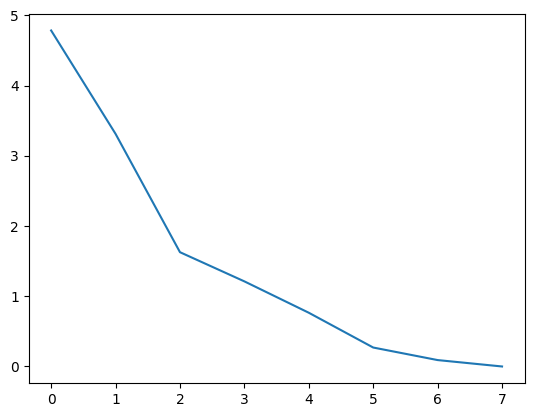

In [146]:
plt.plot(S)

In [138]:
S.shape

(8,)